<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    ML for Bioinformatics <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
<font color=3C99D size=5>
    Homework 2: Practical - Support Vector Machines <br>
<font color=696880 size=4>
    Ali Shafiei (shafieiali42@gmail.com) <br>
    Ali Salmani (alisalmani200149@gmail.com)

____


### Full Name : Sajede Fadaei
### Student Number : 400211513
__

*It is highly recommended to read each codeline carefully and try to understand what it exactly does. Best of luck and have fun!*

# Support Vector Machines (SVM)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.datasets import make_gaussian_quantiles
from sklearn.linear_model import LogisticRegression

In this assignment, we are going to implement Support Vector Machines (SVM) algorithm that determines which patient is in danger and which is not.

In [2]:
df = pd.read_csv("Liver_Disease.csv") 

df.select_dtypes(include=np.number).columns.tolist()

['Age',
 'Total_Bilirubin',
 'Direct_Bilirubin',
 'Alkaline_Phosphotase',
 'Alamine_Aminotransferase',
 'Aspartate_Aminotransferase',
 'Total_Protiens',
 'Albumin',
 'Albumin_and_Globulin_Ratio',
 'label']

### Pre-Processing

#### Exploratory Data Analysis (EDA):
In statistics, exploratory data analysis is an approach to analyze datasets to summarize their main characteristics, often using statistical graphics and other data visualization methods.

This is a general approach that should be applied when you encounter a dataset.

In [3]:
print(df.shape)

print(df.isnull().sum())

(583, 11)
Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
label                         0
dtype: int64


In [4]:
patients_data = df.copy()
patients_data['Albumin_and_Globulin_Ratio']=patients_data['Albumin_and_Globulin_Ratio'].fillna(patients_data['Albumin_and_Globulin_Ratio'].mean())

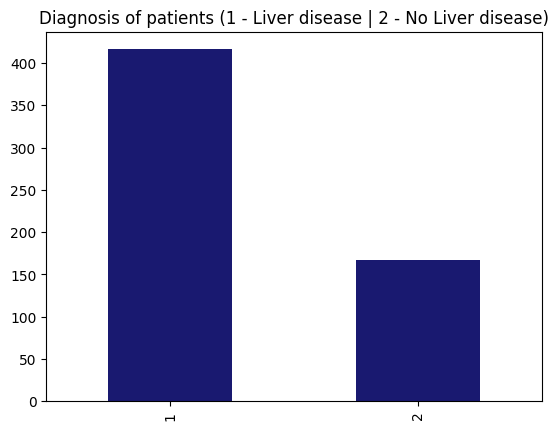

In [5]:
patients_data['label'].value_counts().plot.bar(color='midnightblue')
plt.title('Diagnosis of patients (1 - Liver disease | 2 - No Liver disease)');

#### corresponding plot, dataset is not balanced because the label `1` count is almost twice as the class `2`.

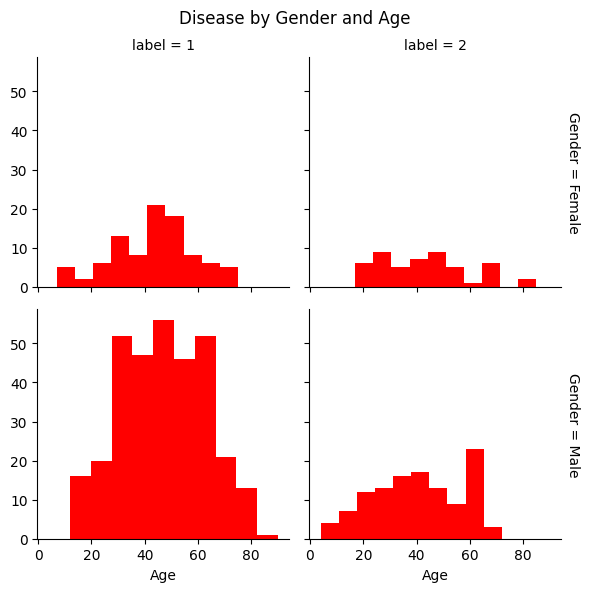

In [6]:
g = sns.FacetGrid(patients_data, col="label", row="Gender", margin_titles=True)
g.map(plt.hist, "Age", color="red")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Disease by Gender and Age');

##### Question: What do you conclude from the plots?
In case of `Gender`, `male` patients were more subject to both labels compared to the `female` subjects.   
While in case of the `Age`, our data is normally distributed with a $\mu \simeq 50$ for both labels.

#### Outlier Detection & Removal
Check whether we have outliers in the data. If there are, delete them.

<AxesSubplot: xlabel='Albumin_and_Globulin_Ratio'>

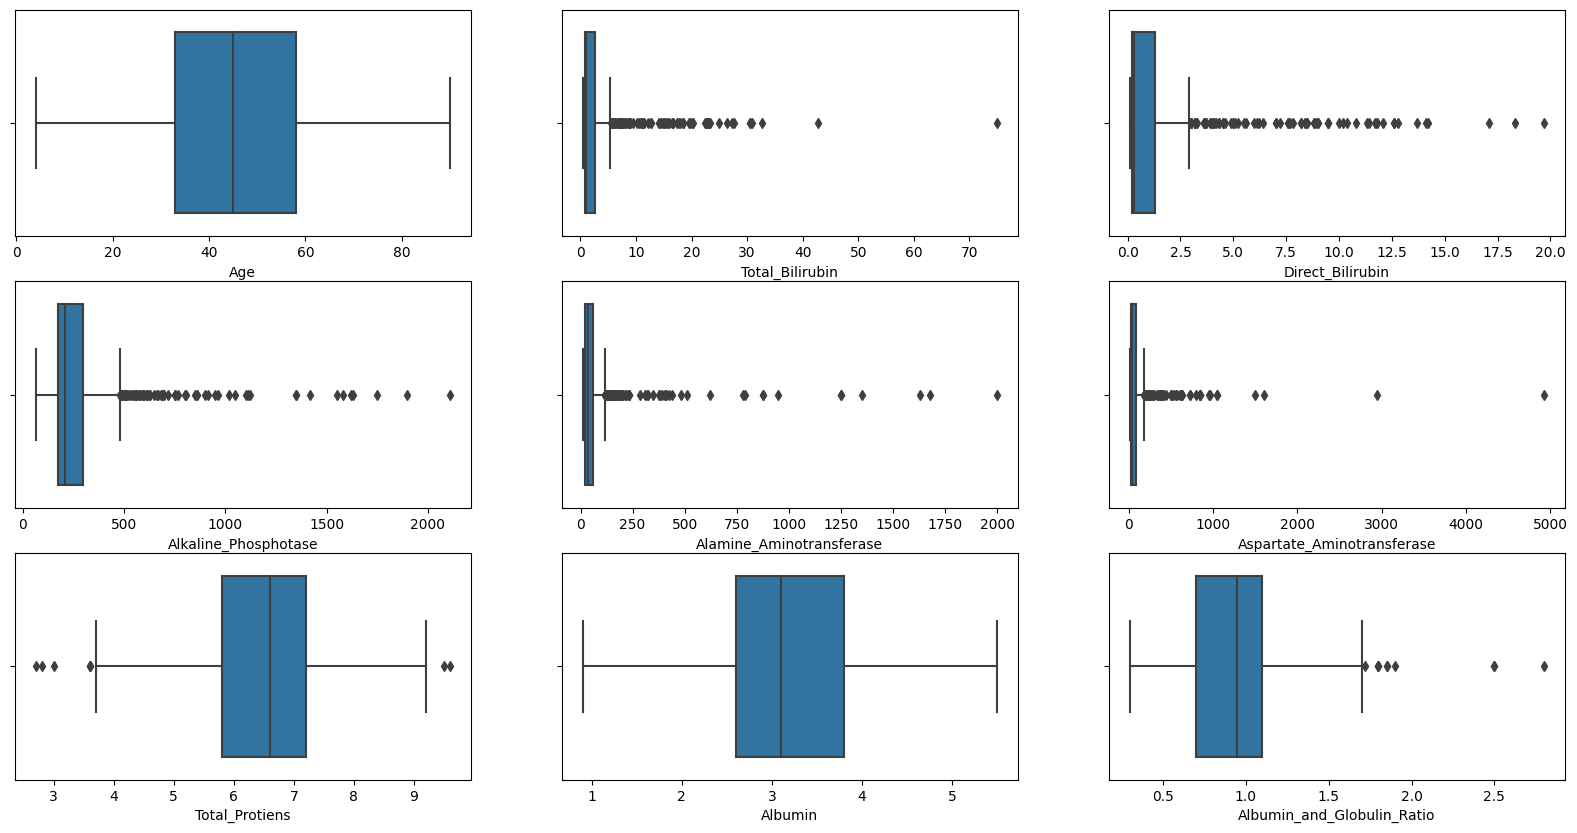

In [7]:
figure, axis = plt.subplots(3, 3, figsize=(20, 10))

sns.boxplot(ax=axis[0, 0], data=patients_data, x='Age')
sns.boxplot(ax=axis[0, 1], data=patients_data, x='Total_Bilirubin')
sns.boxplot(ax=axis[0, 2], data=patients_data, x='Direct_Bilirubin')
sns.boxplot(ax=axis[1, 0], data=patients_data, x='Alkaline_Phosphotase')
sns.boxplot(ax=axis[1, 1], data=patients_data, x='Alamine_Aminotransferase')
sns.boxplot(ax=axis[1, 2], data=patients_data, x='Aspartate_Aminotransferase')
sns.boxplot(ax=axis[2, 0], data=patients_data, x='Total_Protiens')
sns.boxplot(ax=axis[2, 1], data=patients_data, x='Albumin')
sns.boxplot(ax=axis[2, 2], data=patients_data, x='Albumin_and_Globulin_Ratio')

In [8]:
patients_data.Aspartate_Aminotransferase.sort_values(ascending=False).head()

135    4929
117    2946
118    1600
207    1500
119    1050
Name: Aspartate_Aminotransferase, dtype: int64

In [9]:
patients_data = patients_data[patients_data.Aspartate_Aminotransferase <=3000 ]
patients_data = patients_data[patients_data.Aspartate_Aminotransferase <=2500 ]
patients_data

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,label
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1
...,...,...,...,...,...,...,...,...,...,...,...
578,60,Male,0.5,0.1,500,20,34,5.9,1.6,0.37,2
579,40,Male,0.6,0.1,98,35,31,6.0,3.2,1.10,1
580,52,Male,0.8,0.2,245,48,49,6.4,3.2,1.00,1
581,31,Male,1.3,0.5,184,29,32,6.8,3.4,1.00,1


#### Feature Engineering:
Sometimes the collected data are raw; they are either incompatible with your model or hinders its performance. That’s when feature engineering comes to rescue. It encompasses preprocessing techniques to compile a dataset by extracting features from raw data.
also feel free to do more feature engineering techniques if needed.

In [10]:
patients_data_wg = pd.concat([patients_data,pd.get_dummies(patients_data['Gender'], prefix = 'Gender')], axis=1)
patients_data_wg.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,label,Gender_Female,Gender_Male
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1,1,0
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1,0,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1,0,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1,0,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1,0,1


In [11]:
patients_data_wg.reset_index(inplace=True)
patients_data_wg = patients_data_wg.drop(["index"], axis=1)
gender_cat = patients_data_wg[["Gender_Female", "Gender_Male"]]
prepros_data = patients_data_wg.drop(["Gender", "label", "Gender_Female",  "Gender_Male"], axis=1)
prepros_data.head(3)

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,65,0.7,0.1,187,16,18,6.8,3.3,0.90
1,62,10.9,5.5,699,64,100,7.5,3.2,0.74
2,62,7.3,4.1,490,60,68,7.0,3.3,0.89


In [12]:
norm_data = preprocessing.normalize(prepros_data, axis=0)
norm_df = pd.DataFrame(norm_data,columns=[prepros_data.columns])

print('Original Data \n',prepros_data.head(10))
print('Normalized Data \n',norm_df.head(10))


Original Data 
    Age  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
0   65              0.7               0.1                   187   
1   62             10.9               5.5                   699   
2   62              7.3               4.1                   490   
3   58              1.0               0.4                   182   
4   72              3.9               2.0                   195   
5   46              1.8               0.7                   208   
6   26              0.9               0.2                   154   
7   29              0.9               0.3                   202   
8   17              0.9               0.3                   202   
9   55              0.7               0.2                   290   

   Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
0                        16                          18             6.8   
1                        64                         100             7.5   
2                    

In [13]:
norm_df['Gender_male'] = gender_cat["Gender_Male"]
norm_df['Gender_female'] = gender_cat["Gender_Female"]
norm_df

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Gender_male,Gender_female
0,0.056694,0.004147,0.001312,0.020612,0.003809,0.003782,0.042914,0.042229,0.037370,0,1
1,0.054078,0.064570,0.072166,0.077049,0.015236,0.021012,0.047331,0.040950,0.030727,1,0
2,0.054078,0.043244,0.053797,0.054011,0.014284,0.014288,0.044176,0.042229,0.036955,1,0
3,0.050589,0.005924,0.005248,0.020061,0.003333,0.004202,0.042914,0.043509,0.041523,1,0
4,0.062800,0.023103,0.026242,0.021494,0.006428,0.012397,0.046069,0.030712,0.016609,1,0
...,...,...,...,...,...,...,...,...,...,...,...
576,0.052333,0.002962,0.001312,0.055113,0.004761,0.007144,0.037234,0.020475,0.015363,1,0
577,0.034889,0.003554,0.001312,0.010802,0.008332,0.006514,0.037865,0.040950,0.045675,1,0
578,0.045355,0.004739,0.002624,0.027006,0.011427,0.010296,0.040389,0.040950,0.041523,1,0
579,0.027039,0.007701,0.006561,0.020282,0.006904,0.006724,0.042914,0.043509,0.041523,1,0


### SVM

#### spliting data

In [14]:
X = norm_df
y = patients_data["label"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(464, 11)
(464,)
(117, 11)
(117,)


### SVM using Scikit-Learn:
First of all train an svm model with default parameters and report its.

In [16]:
SVclassifier = SVC()
SVclassifier.fit(X_train, y_train)
y_pred = SVclassifier.predict(X_test)

print(f'Accuracy:\t{metrics.accuracy_score(y_test, y_pred)}')
print(f'Precision:\t{metrics.precision_score(y_test, y_pred)}')
print(f'Recall:\t\t{metrics.recall_score(y_test, y_pred)}')

Accuracy:	0.7606837606837606
Precision:	0.7606837606837606
Recall:		1.0


#### Grid Search
Use Grid search and validation set to find the best parameters for your SVM model.

In [17]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ["linear", "rbf", "poly", "sigmoid"]}
grid_search = GridSearchCV(SVclassifier, param_grid, refit=True,verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1

[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...................

[CV] END ......................C=100, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=100, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=100, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=100, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=100, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=100, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             verbose=2)

Train an svm model on the entire training data using the parameters you found in the previous step.

In [18]:
print("Best hyperparameters: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)



svc_best = grid_search.best_estimator_
svc_best.fit(X_train, y_train)
y_pred = svc_best.predict(X_test)

print(f'Accuracy:\t{metrics.accuracy_score(y_test, y_pred)}')
print(f'Precision:\t{metrics.precision_score(y_test, y_pred)}')
print(f'Recall:\t\t{metrics.recall_score(y_test, y_pred)}')

Best hyperparameters:  {'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}
Best ROC AUC score:  0.7025011687704535
Accuracy:	0.7008547008547008
Precision:	0.8
Recall:		0.8089887640449438


### Confusion Matrix
Plot the confusion matrix and report the model accuracy on test set.
What does each entry of the confusion matrix mean?

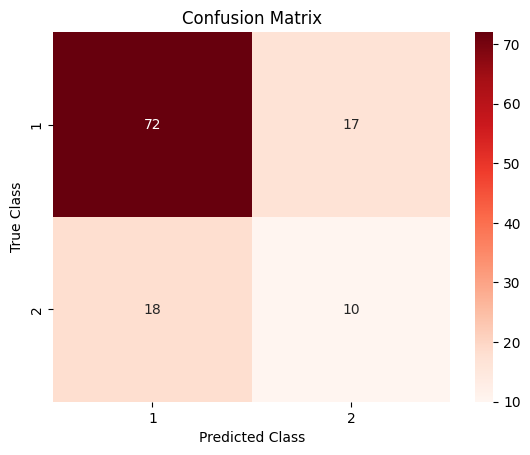

[[72 17]
 [18 10]]


In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
labels = ['1', '2']
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

print(confusion_matrix(y_test, y_pred))

Add some outliers to the dataset, train an SVM and logistic regression model, and compare the results.

In [20]:
X1, y1 = make_gaussian_quantiles(cov=1.,
                                 n_samples=20, n_features=X.shape[1],
                                 n_classes=2, random_state=1)
X1 = abs(X1)
y1[y1 == 0] = 2

X_wo, y_wo = np.vstack([X, X1]), np.hstack([y, y1])
cols = [i[0] for i in X.columns.tolist()]

norm_ = preprocessing.normalize(X_wo, axis=0)
norm_outlier = pd.DataFrame(norm_, columns=cols)

In [21]:
norm_outlier

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Gender_male,Gender_female
0,0.011738,0.001208,0.000300,0.004155,0.000991,0.000699,0.011538,0.009265,0.008594,0.000000,0.079703
1,0.011197,0.018816,0.016485,0.015531,0.003965,0.003882,0.012726,0.008984,0.007066,0.047096,0.000000
2,0.011197,0.012602,0.012289,0.010887,0.003718,0.002640,0.011878,0.009265,0.008499,0.047096,0.000000
3,0.010474,0.001726,0.001199,0.004044,0.000867,0.000776,0.011538,0.009545,0.009549,0.047096,0.000000
4,0.013002,0.006732,0.005995,0.004333,0.001673,0.002290,0.012387,0.006738,0.003820,0.047096,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
596,0.275674,0.083723,0.155348,0.064465,0.331205,0.057932,0.135294,0.283715,0.025400,0.029075,0.044854
597,0.155370,0.154289,0.031455,0.015687,0.160944,0.042956,0.183521,0.068035,0.559944,0.048924,0.174308
598,0.254679,0.160429,0.181101,0.125689,0.135489,0.211432,0.215600,0.010216,0.042906,0.004792,0.069253
599,0.121458,0.244484,0.212692,0.057568,0.230373,0.139385,0.336865,0.112529,0.068553,0.023007,0.006023


In [22]:
X_train, X_test, y_train, y_test = train_test_split(norm_outlier, y_wo, test_size=0.2, random_state=42)

In [23]:
SVclassifier = SVC()
SVclassifier.fit(X_train, y_train)
y_pred = SVclassifier.predict(X_test)

print(f'Accuracy:\t{metrics.accuracy_score(y_test, y_pred)}')
print(f'Precision:\t{metrics.precision_score(y_test, y_pred)}')
print(f'Recall:\t\t{metrics.recall_score(y_test, y_pred)}')

Accuracy:	0.6942148760330579
Precision:	0.6942148760330579
Recall:		1.0


In [24]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
y_pred = logmodel.predict(X_test)

print(f'Accuracy:\t{metrics.accuracy_score(y_test, y_pred)}')
print(f'Precision:\t{metrics.precision_score(y_test, y_pred)}')
print(f'Recall:\t\t{metrics.recall_score(y_test, y_pred)}')

Accuracy:	0.6942148760330579
Precision:	0.6942148760330579
Recall:		1.0


##### SVM and logistic regression model have same Accuracy.